In [40]:
import numpy as np
from datetime import datetime
import collections
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

"Antioquia"
"Bogotá"
"Cartagena"
"Cundinamarca"
"Norte de Santander"
"Quindío"
"Risaralda"
"Valle"


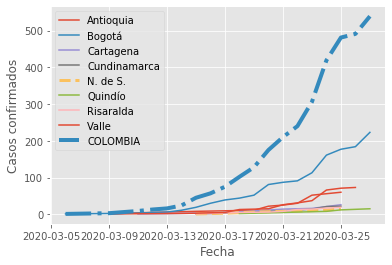

In [10]:
ID,Fecha,Ciudad,Dpto,Atencion = np.loadtxt('Casos_colombia.csv',unpack=True,skiprows=1,dtype=str,usecols=[0,1,2,3,4],delimiter=',')

#Encontrar departamentos donde se ha transmitido
Unicos_dptos = np.unique(Dpto)
plt.style.use('ggplot')
plt.figure()
for i in Unicos_dptos:
    indexes = np.where(Dpto == i )
    Fecha_por_dpto = []
    if len(Fecha[indexes[0]]) >= 15:
        Fecha_por_dpto = Fecha[indexes[0]]
        Fechas_plot = [datetime.strptime(x,'"%d/%m/%Y"') for x in Fecha_por_dpto]
        counter = collections.Counter(Fechas_plot)
        print(i)
        master_data = dict(counter)
        cumulativo = []
        single_vals= []
        Fechas_plot_fin = []
        for x,y in master_data.items():
            single_vals.append(y)
            Fechas_plot_fin.append(x)
        cumulativo = np.cumsum(single_vals)
        if i[1:-1] == 'Norte de Santander':
            plt.plot(Fechas_plot_fin,cumulativo,label='N. de S.',linewidth=3,linestyle='--')
            #plt.semilogy(Fechas_plot_fin,cumulativo,label='N. de S. ' + str(cumulativo[-1]),linewidth=3,linestyle='--')
        else:
            #plt.semilogy(Fechas_plot_fin,cumulativo,label=i[1:-1]+' ' + str(cumulativo[-1]))
            plt.plot(Fechas_plot_fin,cumulativo,label=i[1:-1])

otro_count = collections.Counter(Fecha)
fechas_col,single_colombia=[],[]

for y,x in dict(otro_count).items():
    fechas_col.append(datetime.strptime(y,'"%d/%m/%Y"'))
    single_colombia.append(x)

plt.plot(fechas_col,np.cumsum(single_colombia),label='COLOMBIA',linewidth=4,linestyle='-.')
plt.ylabel('Casos confirmados')
plt.legend()
plt.xlabel('Fecha')
plt.show()

In [28]:
fechas_todas = [datetime.strptime(x,'"%d/%m/%Y"') for x in Fecha]
fecha_primer_caso = min(fechas_todas)

In [33]:
a=primer_caso - max(fechas_todas)
n_depts = 8

8


In [37]:
# Model modified from Thomas Wiecki covid19 GitHub Repo
"""
BSD 3-Clause License

Copyright (c) 2020, Thomas Wiecki
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
"""
#####################################
##### This Cell Runs The Model ######
#####################################

with pm.Model() as model:
    ############
    # Intercept
    # Group mean
    a_grp = pm.Normal('a_grp', 100, 50)
    # Group variance
    a_grp_sigma = pm.HalfNormal('a_grp_sigma', 50)
    # Individual intercepts
    a_ind = pm.Normal('a_ind', 
                      mu=a_grp, sigma=a_grp_sigma, 
                      shape=n_depts)
    ########
    # Slope
    # Group mean
    b_grp = pm.Normal('b_grp', 1.33, .5)
    # Group variance
    b_grp_sigma = pm.HalfNormal('b_grp_sigma', .5)
    # Individual slopes
    b_ind = pm.Normal('b_ind', 
                      mu=b_grp, sigma=b_grp_sigma, 
                      shape=n_depts)
    
    # Error
    sigma = pm.HalfNormal('sigma', 500., shape=n_depts)
    
    # Create likelihood for each country
    dpto_counter = 0
    for i, dpto in enumerate(Unicos_dptos):
        indexes = np.where(Dpto == dpto )
        Fecha_por_dpto = []
        if len(Fecha[indexes[0]]) >= 15:
            Fecha_por_dpto = Fecha[indexes[0]]
            Fechas_plot = [datetime.strptime(x,'"%d/%m/%Y"') for x in Fecha_por_dpto]
            counter = collections.Counter(Fechas_plot)
            master_data = dict(counter)
            cumulativo = []
            single_vals= []
            Fechas_plot_fin = []
            for x,y in master_data.items():
                single_vals.append(y)
                dias_desde_primer_caso = fecha_primer_caso - x
                dias_desde_primer_caso = np.abs(dias_desde_primer_caso.days)
                Fechas_plot_fin.append(dias_desde_primer_caso)
            cumulativo = np.cumsum(single_vals)

            # By using pm.Data we can change these values after sampling.
            # This allows us to extend x into the future so we can get
            # forecasts by sampling from the posterior predictive
            x = pm.Data(dpto + "x_data", 
                        Fechas_plot_fin)
            confirmed = pm.Data(dpto + "y_data", 
                                cumulativo)
            
            print(dpto_counter)
            # Likelihood
            pm.NegativeBinomial(
                dpto, 
                (a_ind[dpto_counter] * b_ind[dpto_counter] ** x), # Exponential regression
                sigma[dpto_counter], 
                observed=confirmed)
            dpto_counter += 1

    

0
1
2
3
4
5
6
7


In [38]:
with model:
    # Sample posterior
    trace = pm.sample(tune=1500, chains=1, cores=1, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, b_ind, b_grp_sigma, b_grp, a_ind, a_grp_sigma, a_grp]
Sampling chain 0, 8 divergences: 100%|██████████| 2000/2000 [03:07<00:00, 10.69it/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [61]:
departamentos = ['"Antioquia"', '"Bogotá"', '"Cartagena"', '"Cundinamarca"', '"Norte de Santander"',
                 '"Quindío"', '"Risaralda"', '"Valle"']

with model:
        # Update data so that we get predictions into the future
    for depto in departamentos:
        x_data = np.arange(0, 30)
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({depto + "x_data": x_data})
        pm.set_data({depto + "y_data": y_data})
    
    # Sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=80)

/Users/ortega/miniconda3/envs/covid_colombia/lib/python3.8/site-packages/pymc3/sampling.py:1246: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
100%|██████████| 80/80 [00:12<00:00,  6.34it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126791f40>,
      dtype=object)

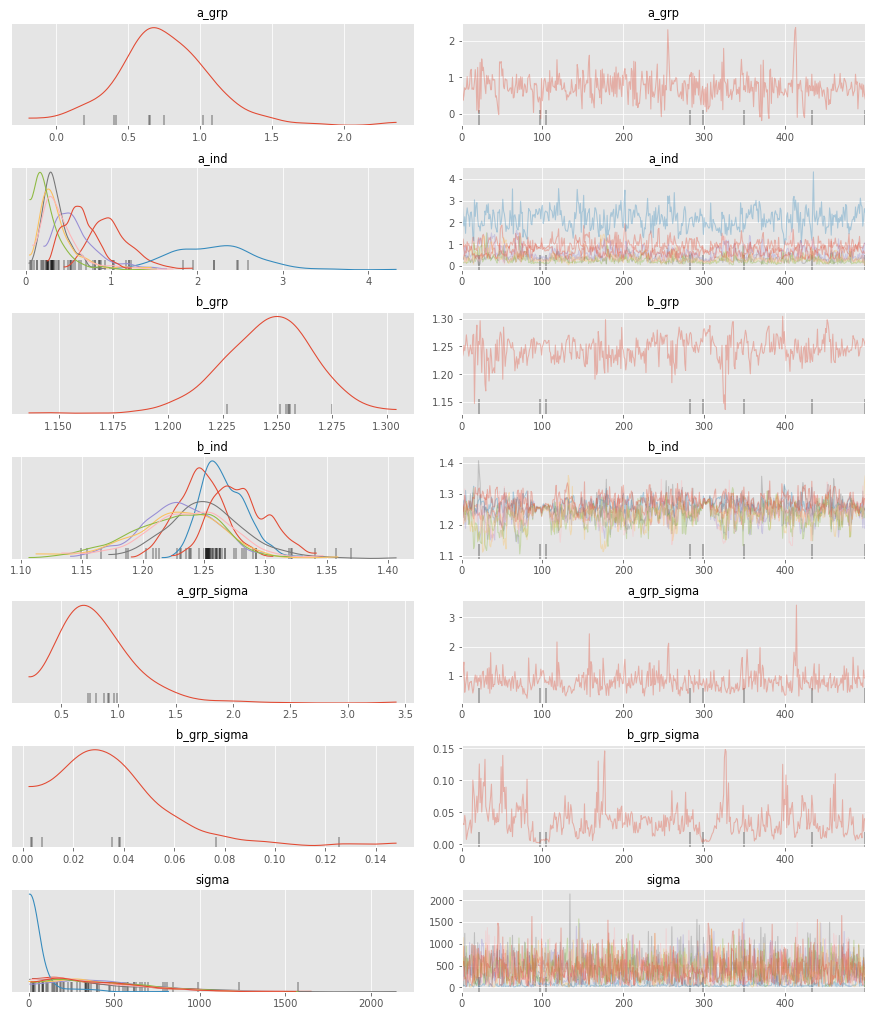

In [43]:
az.plot_trace(trace, compact=True, legend=False)

Text(0.5, 0.98, 'Posterior of daily growth')

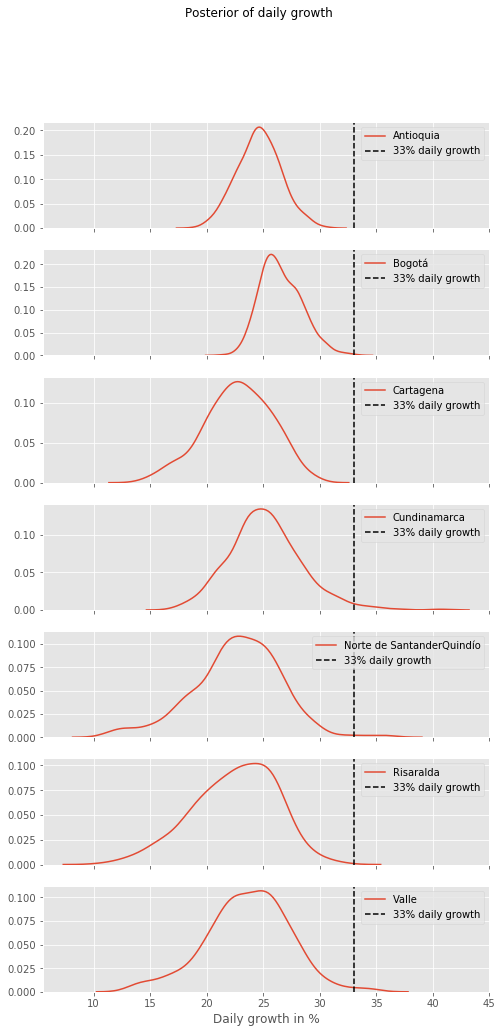

In [53]:
fig, axs = plt.subplots(nrows=len(departamentos), figsize=(8, 16), sharex=True)

for i, depto in enumerate(departamentos):
    sns.distplot((trace['b_ind'][:, i] * 100) - 100, ax=axs[i], label=depto, hist=False)
        
    axs[i].axvline(33, ls='--', color='k', label='33% daily growth')
    axs[i].legend()

axs[-1].set_xlabel('Daily growth in %')
plt.suptitle('Posterior of daily growth')

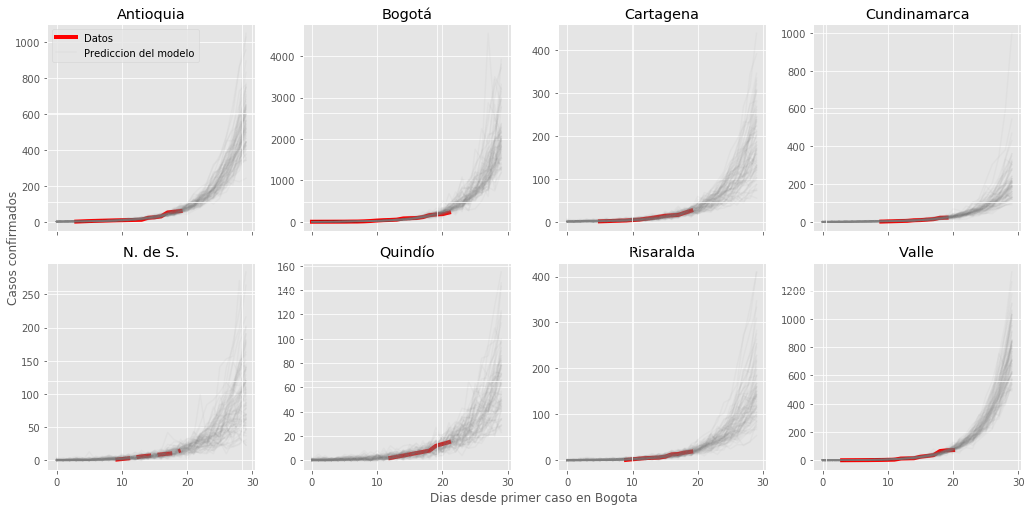

In [90]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 7.5), sharex=True)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Dias desde primer caso en Bogota")
plt.ylabel("Casos confirmados")

axs_flatten = axs.flatten()
dpto_counter = 0
for i, dpto in enumerate(Unicos_dptos):
    indexes = np.where(Dpto == dpto )
    Fecha_por_dpto = []
    if len(Fecha[indexes[0]]) >= 15:
        Fecha_por_dpto = Fecha[indexes[0]]
        Fechas_plot = [datetime.strptime(x,'"%d/%m/%Y"') for x in Fecha_por_dpto]
        counter = collections.Counter(Fechas_plot)
        master_data = dict(counter)
        cumulativo = []
        single_vals= []
        Fechas_plot_fin = []
        for x,y in master_data.items():
            single_vals.append(y)
            dias_desde_primer_caso = fecha_primer_caso - x
            dias_desde_primer_caso = np.abs(dias_desde_primer_caso.days)
            Fechas_plot_fin.append(dias_desde_primer_caso)
        cumulativo = np.cumsum(single_vals)
        if dpto[1:-1] == 'Norte de Santander':
            axs_flatten[dpto_counter].plot(Fechas_plot_fin,cumulativo,label='N. de S.',linewidth=4,linestyle='--', color='r')
            axs_flatten[dpto_counter].plot(np.arange(0, post_pred[dpto].shape[1]), post_pred[dpto].T, alpha=.05, color='.5')
            axs_flatten[dpto_counter].set_title('N. de S.')
            #plt.semilogy(Fechas_plot_fin,cumulativo,label='N. de S. ' + str(cumulativo[-1]),linewidth=3,linestyle='--')
        else:
            #plt.semilogy(Fechas_plot_fin,cumulativo,label=i[1:-1]+' ' + str(cumulativo[-1]))
            axs_flatten[dpto_counter].plot(Fechas_plot_fin,cumulativo,label=dpto[1:-1], color='r', linewidth=4)
            axs_flatten[dpto_counter].plot(np.arange(0, post_pred[dpto].shape[1]), post_pred[dpto].T, alpha=.05, color='.5')
            axs_flatten[dpto_counter].set_title(dpto[1:-1])
        dpto_counter += 1

axs[0, 0].legend(['Datos', 'Prediccion del modelo'])
fig.tight_layout()
fig.savefig('predicciones_colombia.png', dpi=400)
# for ax, country in zip(axs.flatten(), countries):
#     df_country = df.loc[lambda x: x.country == country]
#     ax.plot(df_country.days_since_100, df_country.confirmed, color='r')
#     ax.plot(np.arange(0, post_pred[country].shape[1]), post_pred[country].T, alpha=.05, color='.5')
#     ax.plot(df_country.days_since_100, df_country.confirmed, color='r')
#     #ax.set_yscale('log')
#     #ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#     ax.set_ylim(0, df_country.confirmed.iloc[-1] * 15)
#     ax.set_title(country)

